In [33]:
#import some useful packages

import numpy as np
from qiskit.visualization import array_to_latex
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_formats = ['svg']
import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')


In [3]:
today = time.localtime()
yy = str(today.tm_year)
mm = str(today.tm_mon)
dd = str(today.tm_mday)

In [18]:
folder = name_experiment

In [34]:
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
%config InlineBackend.figure_formats = ['svg']


In [35]:
token = 'c6f7fbd78215239dcf45c2777fa3cc29e68f12ad9e9ded1195e2837c35dd449cfce4ff51c3eb461e2bbcd8efb820f615600fcbdd8330a2093e74a3dbb370aaad'
backend_name = 'ibm_lagos'
qubit = 0
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
NUM_SHOTS = 20000
scale_factor = 1e-7


In [36]:
IBMProvider.save_account(token, overwrite=True)
provider = IBMProvider()
backend = provider.get_backend(backend_name)

In [37]:
#some useful function
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    return LDA_012

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        #print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def IQ_012_plot(x_min, x_max, y_min, y_max, data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

#mitigate
from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    # return np.asarray(sol['x'])
    return np.array([e for e in sol['x']])

def get_population(data, discriminator):
    drag_values = count(data, discriminator)
    return np.asarray([[val['0']/NUM_SHOTS, val['1']/NUM_SHOTS, val['2']/NUM_SHOTS] for val in drag_values])

def get_mitigated_population(data, discriminator, confusion_matrix):
    population = get_population(data, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return np.asarray(mitigated)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#loss function
def loss_func(param, theta, phi, p_exp, N_data = 97):
  p_model = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]
  return mean_squared_error(p_model, population, squared = 'False')

In [39]:
list_id = np.genfromtxt('Interleaved Randomized Benchmarking/job_id_irmb_hadamard_2023_8_29_lagos_c6f.txt', dtype='str')

In [40]:
import pandas as pd

In [51]:
populations = []
mats = []
for i in range(50):
    print(f'Processing {i+1}/50', end='\r')
    interleaved_rmb_data = pd.read_csv(f'Interleaved Randomized Benchmarking/data_irmb_hadamard_2023_8_29_lagos_{i+1}.csv', header=None)
    interleaved_rmb_data = interleaved_rmb_data.applymap(lambda s: complex(s.replace('i', 'j'))).values
    discrim_data = interleaved_rmb_data[:3]
    exp_data = interleaved_rmb_data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    mats.append(conf_mat)
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)

In [52]:
length = np.arange(1, 98)

In [53]:
rmb_populations = [populations[i][:, 0] for i in range(len(populations))]
rmb_populations = np.array([list(population) for population in rmb_populations])

In [55]:
average_populations = np.zeros((1, 97))
for i in range(len(populations)):
    average_populations = average_populations + populations[i][:, 0]


In [56]:
average_populations = average_populations/len(populations)
average_populations

array([[0.94017579, 0.95831401, 0.93055316, 0.90734497, 0.87332024,
        0.85424415, 0.84862201, 0.84009635, 0.81784061, 0.79662857,
        0.80825914, 0.79518295, 0.77688931, 0.76201464, 0.72177829,
        0.75262896, 0.69785911, 0.70755719, 0.71676994, 0.69048805,
        0.66034947, 0.68236191, 0.64665029, 0.67309268, 0.65893803,
        0.62161266, 0.62438616, 0.63675055, 0.61473111, 0.59503926,
        0.6122885 , 0.59907655, 0.59024247, 0.59458444, 0.58328233,
        0.57462344, 0.55808256, 0.554193  , 0.56508069, 0.54722088,
        0.55772081, 0.54395268, 0.55724113, 0.56883266, 0.52171122,
        0.54386278, 0.53974732, 0.52442372, 0.53516606, 0.51581772,
        0.51004064, 0.49764345, 0.51429215, 0.53658031, 0.49266721,
        0.52241289, 0.51529727, 0.51245487, 0.49396992, 0.50446156,
        0.50193128, 0.52567923, 0.49924557, 0.45906698, 0.5111566 ,
        0.4993247 , 0.49307511, 0.47828211, 0.4708529 , 0.48798178,
        0.4808117 , 0.45186077, 0.46544492, 0.47

In [60]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit
from scipy.optimize import curve_fit
fit_params, y_fit = fit_function(length, 
                                 average_populations[0], 
                                 lambda m, A, B, p: A*p**m + B,
                                 [0.5, 0.5, 1])

In [61]:
A, B, p = fit_params
p

0.9641913109342417

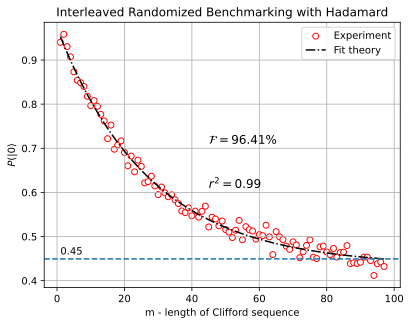

In [66]:
plt.scatter(length, average_populations[0], marker='o', edgecolor='red', color='white', label='Experiment')
plt.plot(length, y_fit, linestyle='-.', color='black', linewidth=1.5, label='Fit theory')
plt.grid()
plt.legend()
plt.axhline(y_fit[-1], linestyle='--')
plt.annotate("", xy=(1, 0), xytext=(1/2,0), arrowprops=dict(arrowstyle="<->"))
plt.annotate(np.round(y_fit[-1], 2), xy=(1, y_fit[-1]+0.01))
plt.xlabel('m - length of Clifford sequence')
plt.text(45, 0.71, r'$\mathcal{F}=96.41\%$', fontsize=12)
plt.text(45, 0.61, fr'$r^2={np.round(r2_score(average_populations[0], y_fit), 2)}$', fontsize=12)
plt.title('Interleaved Randomized Benchmarking with Hadamard')
plt.ylabel(r'$P(|0\rangle$')

plt.savefig('irmb_hadamard_2023_29_08_lagos')